In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from imageio import imread, imwrite

import os, copy, time

from horsetools import list_files
from fcn import VGGNet, FCNs

plt.ion()

## Load data

In [16]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

    
class SegmentationDataset(Dataset):
    IMG_EXTS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif')
    
    def _get_files(self, folder):
        if os.path.isdir(folder):
            return sorted(list_files(folder, valid_exts=self.IMG_EXTS))
        else:
            raise(RuntimeError('No folder named "{}" found.'.format(folder)))
    
    def __init__(self, root, labels, image_transforms=None, mask_transforms=None):
        self.imgs = self._get_files(os.path.join(root, 'images'))
        self.masks = self._get_files(os.path.join(root, 'masks'))
        self.labels = labels
        
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        img = default_loader(self.imgs[index])
        mask = default_loader(self.masks[index])
        if self.image_transforms is not None:
            img = self.image_transforms(img)
        if self.mask_transforms is not None:
            mask = self.mask_transforms(mask)
            
        return img, mask

In [5]:
# find means and stds of dataset
imgs_list = list_files('stroma_epithelia/images')
np_means = np.zeros((len(imgs_list), 3))
np_stds = np.zeros_like(np_means)
for i, img_name in enumerate(imgs_list):
    img = imread(img_name)
    np_means[i] = np.mean(img, axis=(0, 1))
    np_stds[i] = np.std(img, axis=(0, 1))
    
channel_means = np.mean(np_means, axis=0)
channel_stds = np.std(np_stds, axis=0)

In [6]:
print('Means: {}'.format(channel_means))
print('Stds: {}'.format(channel_stds))

Means: [164.60564156 150.75147313 178.36823845]
Stds: [ 9.46653235 16.23701039  9.48000306]


In [7]:
data_root = 'stroma_epithelia'
crop_size = 224
labels = (0, 1, 2)
dataset_phases = ['train']

n_labels = len(labels)

In [8]:
class LabelToOnehot(object):
    def __init__ (self, labels):
        self.labels = labels
        
    def __call__(self, img):
        img = np.array(img)
        
        if len(img.shape) > 2:
            img = img[:, :, 0]
            
        onehot = np.zeros((img.shape[0], img.shape[1], len(self.labels)))
        for i, l in enumerate(self.labels):
            onehot[:, :, i] = img == l
            
        return onehot
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

data_transforms = {
    'train': {
        'imgs': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(channel_means, channel_stds)
        ]),
        'masks': transforms.Compose([
            transforms.CenterCrop(crop_size),
            LabelToOnehot(labels),
            transforms.ToTensor()
        ])
    }
}

image_datasets = {x: SegmentationDataset(data_root, labels, 
                                         image_transforms=data_transforms[x]['imgs'],
                                         mask_transforms=data_transforms[x]['masks'])
                  for x in dataset_phases}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, 
                             shuffle=True, num_workers=4)
               for x in dataset_phases}
dataset_sizes = {x: len(image_datasets[x]) for x in dataset_phases}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

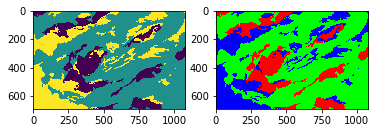

In [9]:
# test onehot 
mask_name = 'stroma_epithelia/masks/0.1_110_2_1.png'
mask = imread(mask_name)
LO = LabelToOnehot(labels)
mask_oh = LO(mask)

plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(mask_oh)

## Visualize images

Image shape: torch.Size([4, 3, 224, 224])
Masks shape: torch.Size([4, 3, 224, 224])


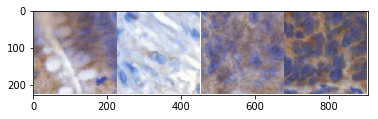

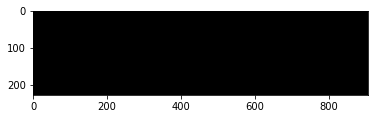

In [10]:
def imshow(inp, means=None, stds=None, title=None):
    # convert tensor back to image range [0, 1]
    inp = inp.numpy().transpose((1, 2, 0))
    
    if means is not None and stds is not None:
        inp = np.array(stds) * inp + np.array(means)
        inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, masks = next(iter(dataloaders['train']))
print('Image shape: {}'.format(inputs.shape))
print('Masks shape: {}'.format(masks.shape))
imshow(torchvision.utils.make_grid(inputs), means=channel_means, stds=channel_stds)
imshow(torchvision.utils.make_grid(masks))

## Define training protocol

In [11]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, 
                phases, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # display epoch
        print('Epoch {} / {}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            # reset loss for current phase and epoch
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # track history only during training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, dataloaders, labels, num_images=6):
    # save model training state to reset once finished
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # without applying gradients
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # evaluate inputs
            outputs = model(inputs)
            # find argmax of class predictions
            _, preds = torch.max(outputs, 1)
            
            # for all images in inputs
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(labels[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

## Define model

In [14]:
learn_rate = 0.001
momentum = 0.9
step_size = 50
gamma = 0.5

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_labels)

fcn_model = fcn_model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.SGD(fcn_model.parameters(), lr=learn_rate, momentum=momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

## Train and evaluate

In [17]:
fcn_model = train_model(fcn_model, dataloaders, criterion, optimizer_ft, 
                        scheduler, dataset_phases, num_epochs=25)
visualize_model(fcn_model, dataloaders, labels)

Epoch 0 / 24
----------


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1525812548180/work/aten/src/THC/generic/THCStorage.cu:58